In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

# For BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

2024-11-02 17:05:43.639797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 17:05:43.651850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 17:05:43.655489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 17:05:43.665688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 17:05:44.535081: W tensorflow/compiler/tf2

This notebook serves as a playground for testing continuous-time consistency models. Later on, it will probably evolve into a full tutorial notebook. For now, please refer to the starter notebook if you encounter concepts that are not explained.

In [2]:
def theta_prior():
    theta = np.random.uniform(-1, 1, 2)
    return dict(theta=theta)

def forward_model(theta):
    alpha = np.random.uniform(-np.pi / 2, np.pi / 2)
    r = np.random.normal(0.1, 0.01)
    x1 = -np.abs(theta[0] + theta[1]) / np.sqrt(2) + r * np.cos(alpha) + 0.25
    x2 = (-theta[0] + theta[1]) / np.sqrt(2) + r * np.sin(alpha)
    return dict(x=np.array([x1, x2]))

simulator = bf.make_simulator([theta_prior, forward_model])

Let's generate some data to see what the simulator does:

In [3]:
# generate 3 random draws from the joint distribution p(r, alpha, theta, x)
sample_data = simulator.sample((20,))

In [4]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['theta', 'x'])
Types of sample_data values:
	 {'theta': <class 'numpy.ndarray'>, 'x': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'theta': (20, 2), 'x': (20, 2)}


In [5]:
adapter = (
    bf.adapters.Adapter()
    
    # convert any non-arrays to numpy arrays
    .to_array()
    
    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")
    
    # standardize all variables to zero mean and unit variance
    .standardize(momentum=None)  # standardization with momentum is currently not working
    
    # rename the variables to match the required approximator inputs
    .rename("theta", "inference_variables")
    .rename("x", "inference_conditions")
)
adapter

Adapter([ToArray -> ConvertDType -> Standardize -> Rename('theta' -> 'inference_variables') -> Rename('x' -> 'inference_conditions')])

## Dataset

For this example, we will sample our training data ahead of time and use offline training with a `bf.datasets.OfflineDataset`.

This makes the training process faster, since we avoid repeated sampling. If you want to use online training, you can use an `OnlineDataset` analogously, or just pass your simulator directly to `approximator.fit()`!

In [6]:
num_training_batches = 512
num_validation_batches = 128
batch_size = 64
epochs = 30
total_steps = num_training_batches * epochs

In [7]:
training_samples = simulator.sample((num_training_batches * batch_size,))
validation_samples = simulator.sample((num_validation_batches * batch_size,))

In [8]:
training_dataset = bf.datasets.OfflineDataset(
    data=training_samples, 
    batch_size=batch_size, 
    adapter=adapter
)

validation_dataset = bf.datasets.OfflineDataset(
    data=validation_samples, 
    batch_size=batch_size, 
    adapter=adapter
)

## Training a neural network to approximate all posteriors

In [9]:
inference_network = bf.networks.ContinuousConsistencyModel(
    subnet="mlp",
    sigma_data=1.0,  # as we have standardized our parameters, the standard deviation is 1.0
    time_emb_dim=20,  # it is unclear whether the time embedding is necessary for smaller problems, here we include it
    subnet_kwargs={"widths": (256,)*6, "dropout": 0.0, } # use an inner network with 6 hidden layers of 256 units
)

This inference network is just a general Flow Matching backbone, not yet adapted to the specific inference task at hand (i.e., posterior appproximation). To achieve this adaptation, we combine the network with our data adapter, which together form an `approximator`. In this case, we need a `ContinuousApproximator` since the target we want to approximate is the posterior of the *continuous* parameter vector $\theta$.

In [10]:
cm_approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    adapter=adapter,
)

### Optimizer and Learning Rate
We find learning rate schedules, such as [cosine decay](https://keras.io/api/optimizers/learning_rate_schedules/cosine_decay/), work well for a wide variety of approximation tasks.

In [11]:
initial_learning_rate = 5e-4
scheduled_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=total_steps,
    alpha=1e-8
)

optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)

In [12]:
cm_approximator.compile(optimizer=optimizer)

### Training

We are ready to train our deep posterior approximator on the two moons example. We pass the dataset object to the `fit` method and watch as Bayesflow trains.

In [13]:
%%time
fm_history = cm_approximator.fit(
    epochs=epochs,
    dataset=training_dataset,
    validation_data=validation_dataset,
    verbose=2,  # set verbose=2 to avoid flooding the notebook
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
512/512 - 5s - 10ms/step - loss: -4.5755e+00 - loss/inference_loss: -4.5755e+00 - val_loss: -4.5809e+00 - val_loss/inference_loss: -4.5809e+00
Epoch 2/30
512/512 - 2s - 5ms/step - loss: -4.5826e+00 - loss/inference_loss: -4.5826e+00 - val_loss: -4.5783e+00 - val_loss/inference_loss: -4.5783e+00
Epoch 3/30
512/512 - 2s - 5ms/step - loss: -4.5763e+00 - loss/inference_loss: -4.5763e+00 - val_loss: -4.5819e+00 - val_loss/inference_loss: -4.5819e+00
Epoch 4/30
512/512 - 2s - 5ms/step - loss: -4.5861e+00 - loss/inference_loss: -4.5861e+00 - val_loss: -4.5717e+00 - val_loss/inference_loss: -4.5717e+00
Epoch 5/30
512/512 - 3s - 5ms/step - loss: -4.5905e+00 - loss/inference_loss: -4.5905e+00 - val_loss: -4.5821e+00 - val_loss/inference_loss: -4.5821e+00
Epoch 6/30
512/512 - 2s - 5ms/step - loss: -4.5799e+00 - loss/inference_loss: -4.5799e+00 - val_loss: -4.5839e+00 - val_loss/inference_loss: -4.5839e+00
Epoch 7/30
512/512 - 2s - 5ms/step - loss: -4.5816e+00 - loss/inference_loss: -4.

Note that after a certain time, the loss is no longer indicative of training performance.

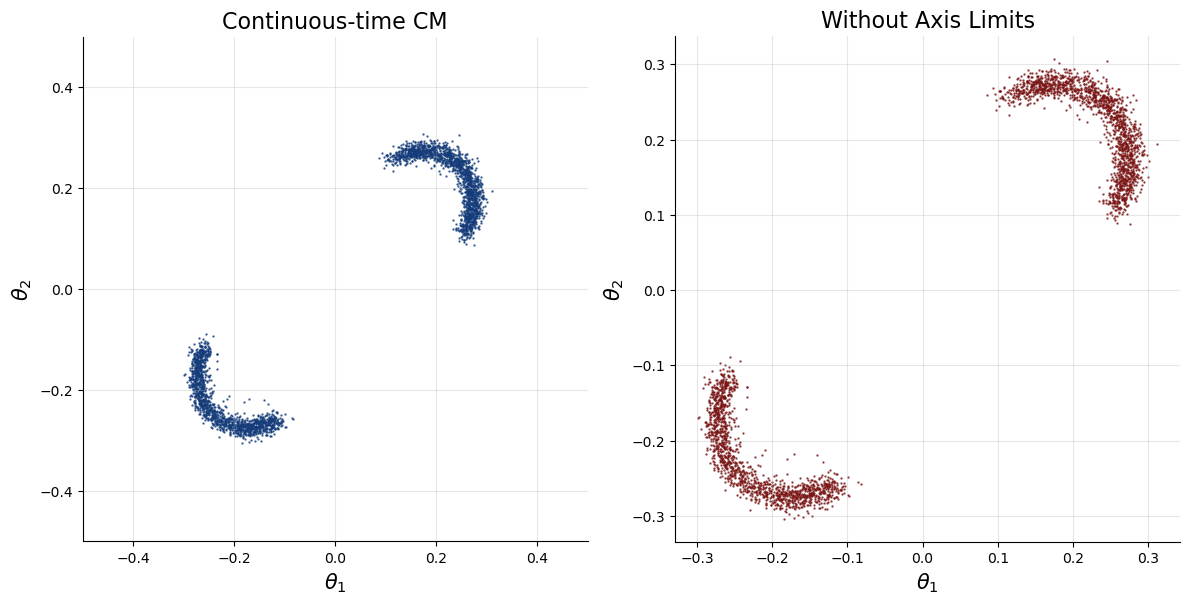

In [14]:
# Set the number of posterior draws you want to get
num_samples = 3000

# Obtain samples from amortized posterior

# conditions = {"x": np.array([[0.0, 0.0]]).astype("float32")}
# samples_0 = cm_approximator.sample(conditions=conditions, batch_size=1, num_samples=num_samples)["theta"][0]

# manually sample using _inverse to have access to sampling parameters
# (will not be necessary anymore when .sample forwards those arguments.
# Take care to correctly apply the data adapter.
samples_0 = adapter.inverse({
    "inference_variables": keras.ops.convert_to_numpy(
        cm_approximator.inference_network._inverse(
            keras.random.normal((num_samples, 2)),
            conditions=adapter.forward({"x": np.zeros((num_samples, 2))}, strict=False)["inference_conditions"],
            steps=30, max_noise=10.0, rho=7.0)
    ),
}, strict=False)["theta"]

# Prepare figure
f, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot samples (once without limits to see outliers/problems
samples = [samples_0, samples_0]
names = ["Continuous-time CM", "Without Axis Limits"]
colors = ["#153c7a", "#7a1515"]

for ax, thetas, name, color in zip(axes, samples, names, colors):

    # Plot samples
    ax.scatter(thetas[:, 0], thetas[:, 1], color=color, alpha=0.75, s=0.5)
    sns.despine(ax=ax)
    ax.set_title(f"{name}", fontsize=16)
    ax.grid(alpha=0.3)
    ax.set_aspect("equal", adjustable="box")
    if not name.lower().startswith("without"):
        ax.set_xlim([-0.5, 0.5])
        ax.set_ylim([-0.5, 0.5])
    ax.set_xlabel(r"$\theta_1$", fontsize=15)
    ax.set_ylabel(r"$\theta_2$", fontsize=15)

f.tight_layout()

Plot the time embedding:

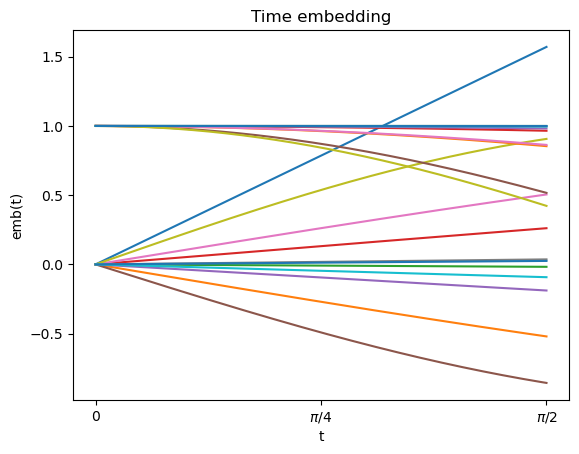

In [15]:
t = keras.ops.linspace(0, np.pi/2, 500)[:, None]
emb = inference_network.time_emb(t)
plt.plot(keras.ops.convert_to_numpy(t)[:,0], keras.ops.convert_to_numpy(emb))
plt.ylabel("emb(t)")
plt.xlabel("t")
plt.xticks([0.0, np.pi/4, np.pi/2], labels=["0", "$\pi/4$", "$\pi/2$"])
_ = plt.title("Time embedding")

Plot the learned adaptive weighting function:

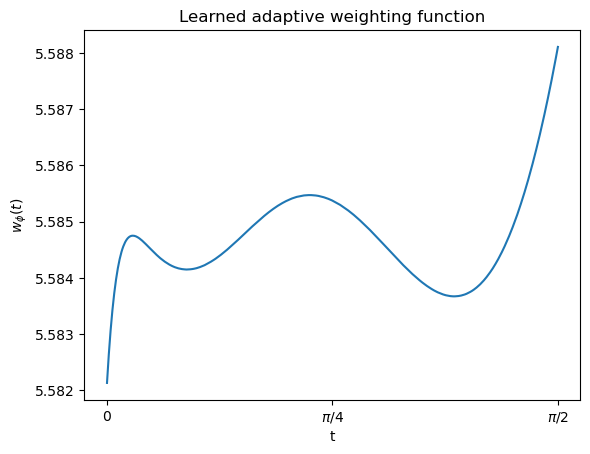

In [16]:
plt.plot(t, inference_network.weight_fn_projector(inference_network.weight_fn(t)))
plt.ylabel("$w_\phi(t)$")
plt.xlabel("t")
plt.xticks([0.0, np.pi/4, np.pi/2], labels=["0", "$\pi/4$", "$\pi/2$"])
_ = plt.title("Learned adaptive weighting function")